In [1]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import make_pipeline, Pipeline
from scipy import stats
from scipy.stats import ttest_1samp, wilcoxon
from statistics import mean, stdev
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,  ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.feature_selection import RFE, RFECV, SelectFromModel, SelectKBest, f_classif 
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, recall_score, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, precision_recall_curve, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_validate, RepeatedStratifiedKFold
#from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from time import time
import tracemalloc
#!pip install skrebate
#from skrebate import ReliefF
#!pip install xgboost
#from xgboost import XGBClassifier

### _Data Loading_

In [2]:
# Data loading
hf=pd.read_csv('C:/Users/14169/OneDrive/Documents/CIND 820/heart_failure_clinical_records_dataset.csv')
hf=hf.drop("time",axis=1)
hf.info()

# Map variables
hf["age"]=hf["age"].astype("int64")
hf["platelets"]=hf["platelets"].map(lambda x:x/1000.00)
hf.info()
hf.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Da

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75,0,582,0,20,1,265.00000,1.9,130,1,0,1
1,55,0,7861,0,38,0,263.35803,1.1,136,1,0,1
2,65,0,146,0,20,0,162.00000,1.3,129,1,1,1
3,50,1,111,0,20,0,210.00000,1.9,137,1,0,1
4,65,1,160,1,20,0,327.00000,2.7,116,0,0,1
5,90,1,47,0,40,1,204.00000,2.1,132,1,1,1
6,75,1,246,0,15,0,127.00000,1.2,137,1,0,1
7,60,1,315,1,60,0,454.00000,1.1,131,1,1,1
8,65,0,157,0,65,0,263.35803,1.5,138,0,0,1
9,80,1,123,0,35,1,388.00000,9.4,133,1,1,1


### _Data Feature Engineering_

#### Standardization and Class Balancing

In [3]:
# Preprocessing mixed data types using standard scaler for numeric and passthrough for other variables
numerical_features = ['creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine',
                       'serum_sodium']
passthrough_features = ['age','anaemia','high_blood_pressure','diabetes','sex','smoking']

# Define the data preparation for the columns
preprocessor = ColumnTransformer(
    transformers=[("num", RobustScaler(), numerical_features),
                  ("pass", 'passthrough', passthrough_features)])

# Model resampling to correct class imbalance
smote_enn = SMOTEENN(sampling_strategy='auto', enn=(EditedNearestNeighbours(kind_sel='mode')), random_state=0)
#smote = SMOTE(sampling_strategy='minority', random_state=0)

### _Data Splitting_

In [4]:
# Split the data into features (X) and target (y)
# DEATH_EVENT is target variable
X=hf.drop("DEATH_EVENT",axis=1)
y=hf["DEATH_EVENT"]

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

X_trans = preprocessor.fit_transform(X_train)
X_resampled, y_resampled = smote_enn.fit_resample(X_trans, y_train)

print('Original Training Class Distribution\n')
print(y_train.value_counts())
print('\nResampled Class Distribution')
print(y_resampled.value_counts())

Original Training Class Distribution

0    162
1     77
Name: DEATH_EVENT, dtype: int64

Resampled Class Distribution
0    162
1    152
Name: DEATH_EVENT, dtype: int64


### _Hyperparameter Tuning_

#### Tree-based Classifier Hyperparameter Tuning

In [35]:
# Define the hyperparameter grid to search
param_dist = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 30], 
    'min_samples_split': [5, 10],                         
    'max_features': ['sqrt', 'log2'],   
    'max_leaf_nodes': [ 50, 100],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy']
}
    
#grid_search = GridSearchCV(RandomForestClassifier(), param_dist, cv=5, scoring='roc_auc')
grid_search = GridSearchCV(ExtraTreesClassifier(), param_dist, cv=5, scoring='roc_auc')

grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross_validated ROC AUC: {:.2f}".format (grid_search.best_score_))
print(grid_search.best_estimator_)

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 100, 'min_samples_split': 5, 'n_estimators': 500}
Best Cross_validated ROC AUC: 0.95
ExtraTreesClassifier(class_weight='balanced', max_depth=30, max_features='sqrt',
                     max_leaf_nodes=100, min_samples_split=5, n_estimators=500)


#### Logistic Regression Hyperparameter Tuning

In [27]:
# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.5, 1.0, 1.5],
    'class_weight': ['balanced'],
    'solver': ['liblinear'],
    'max_iter': [200, 500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Cross-validated ROC AUC: {:.2f}".format(grid_search.best_score_))
print(grid_search.best_estimator_)

Best Hyperparameters:  {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-validated Accuracy: 0.83
LogisticRegression(C=0.5, class_weight='balanced', max_iter=200, penalty='l1',
                   solver='liblinear')


####  AdaBoost Hyperparameter Tuning

In [44]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.1, 0.5, 1.0],
    'base_estimator': [LogisticRegression()]
}

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Cross-validated ROC AUC: {:.2f}".format(grid_search.best_score_))
print(grid_search.best_estimator_)

Best Hyperparameters:  {'base_estimator': LogisticRegression(), 'learning_rate': 0.1, 'n_estimators': 500}
Best Cross-validated Accuracy: 0.82
AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.1,
                   n_estimators=500)


### _Model Training, Fitting and Evaluating_

#### Model Training 

In [7]:
# STEP 1:  Define the classifier 

#clf = RandomForestClassifier()
clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=10, max_features='log2', max_leaf_nodes=50, min_samples_split=5, n_estimators=500)
#clf = ExtraTreesClassifier()
#clf = ExtraTreesClassifier(class_weight='balanced', max_depth=30, max_features='log2', max_leaf_nodes=100, min_samples_split=5, n_estimators=500)
#clf = LogisticRegression(max_iter=1000)
#clf = LogisticRegression(C=0.5, class_weight='balanced', max_iter=200, penalty='l1', solver='liblinear')
#clf = AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced'), learning_rate=0.1, n_estimators=500)

# STEP 2:  Define model pipelines for preprocessing, feature selection and classifier

# Imbalanced dataset; complete feature set
#model = Pipeline([('pre', preprocessor), ('classifier', clf)])

# Balanced dataset; complete feature set
#model = Pipeline([('pre', preprocessor), ('smote', smote_enn), ('classifier', clf)])
                 
# Balanced dataset; feature selections using RF with SFM
model = Pipeline([('pre',preprocessor), ('smote',smote_enn), ('fs',SelectFromModel(clf)), ('classifier',clf)])

#### Model Fitting and Evaluating

In [8]:
scoring_metrics = {
    'mcc': make_scorer(matthews_corrcoef), 
    'f1_score': 'f1', 
    'accuracy': 'accuracy',
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'recall': 'recall',
    'precision': 'precision', 
    'ROC_AUC': 'roc_auc'}

# Initialize a list to store model elvaluation scores
mcc_scores = []
f1_scores = []
accuracy_scores = []
balanced_accuracy_scores = []
recall_scores = []
precision_scores = []
AUC_ROC_scores = []

start_time = time()
# Start tracing memory allocations
tracemalloc.start()

n=10
k=10
# Perform repeated stratified K-fold cross validation and obtain model evaluation scores
rskf = RepeatedStratifiedKFold(n_repeats=n, n_splits=k, random_state=0)

for i, (train_index, test_index) in enumerate(rskf.split(X, y)):
    
    model.fit(X_train, y_train)    
  
    y_pred = model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1] 
   
    mcc = matthews_corrcoef(y_test, y_pred)
    mcc_scores.append(mcc)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)        
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    bal_accuracy = balanced_accuracy_score(y_test, y_pred)
    balanced_accuracy_scores.append(bal_accuracy)
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)   
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)        
    AUC_ROC = roc_auc_score(y_test,y_pred_prob)
    AUC_ROC_scores.append(AUC_ROC)
    
elapsed_time = time() - start_time
print(f"Elaspsed time to cross_validate Model: {elapsed_time:.1f} seconds\n")
# Stop tracing and print memory statistics
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage: {current / 10**6} MB")
print(f"Peak memory usage: {peak / 10**6} MB\n")
# Reset the trace
tracemalloc.stop()

# Calculate and print the model mean and sd, evaluation scores
print('MCC: mean %.3f sd %.3f' % (mean(mcc_scores), stdev(mcc_scores)))
print('F1 Score: mean %.3f sd %.3f' % (mean(f1_scores), stdev(f1_scores)))
print('Accuracy: mean %.3f sd %.3f' % (mean(accuracy_scores), stdev(accuracy_scores)))
print('Balanced Accuracy: mean %.3f sd %.3f' % (mean(balanced_accuracy_scores), stdev(balanced_accuracy_scores)))
print('Recall: mean %.3f sd %.3f' % (mean(recall_scores), stdev(recall_scores)))
print('Precision: mean %.3f sd %.3f' % (mean(precision_scores), stdev(precision_scores)))
print('AUC-ROC: mean %.3f sd %.3f' % (mean(AUC_ROC_scores), stdev(AUC_ROC_scores)))

Elaspsed time to cross_validate Model: 973.0 seconds

Current memory usage: 0.776221 MB
Peak memory usage: 1.010301 MB

MCC: mean 0.520 sd 0.038
F1 Score: mean 0.681 sd 0.026
Accuracy: mean 0.781 sd 0.016
Balanced Accuracy: mean 0.770 sd 0.021
Recall: mean 0.737 sd 0.039
Precision: mean 0.633 sd 0.021
AUC-ROC: mean 0.777 sd 0.007


#### Permutation Feature Importances

Ranked Permutation Feature Importances:
serum_creatinine: 0.0750
ejection_fraction: 0.0683
age: 0.0550
serum_sodium: 0.0100
anaemia: 0.0000
diabetes: 0.0000
high_blood_pressure: 0.0000
platelets: 0.0000
sex: 0.0000
smoking: 0.0000
creatinine_phosphokinase: -0.0033


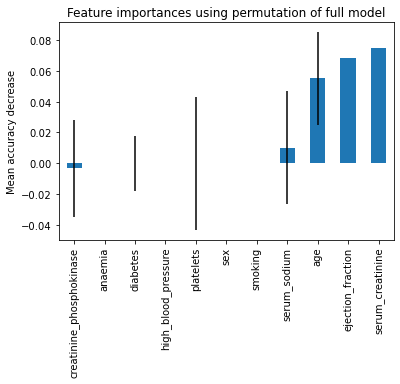

In [9]:
# Feature Importance Ranking from Permutation Importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
feature_names = X_test.columns

# Access the importances from the result
feature_importances = result.importances_mean
sorted_features = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

# Print the Ranked Permutation Feature Importances
print("Ranked Permutation Feature Importances:")
for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")

# Plot the Ranked Permutation Feature Importances
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)
feature_names = X_test.columns
model_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=True)
fix, ax = plt.subplots()
model_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation of full model")
ax.set_ylabel("Mean accuracy decrease")
plt.figure
plt.show()

#### Feature Importance for Tree Classifiers

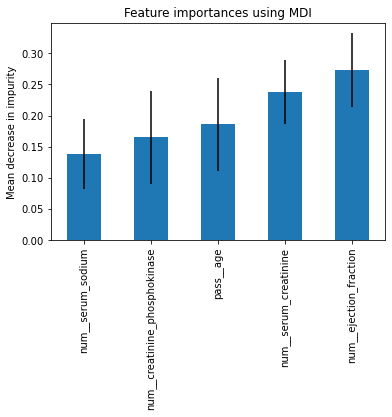

<Figure size 216x144 with 0 Axes>

In [10]:
# Feature Importance Ranking from Mean Decrease in Impurity

feature_names = model[:-1].get_feature_names_out()

importances = model[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

model_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)
fig, ax = plt.subplots()
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
figure(figsize=(3,2))
plt.show()

### _Hypothesis Statistical Siginificance Testing_

In [15]:
# Check for normalcy in the data using the Shapiro-Wilk test

# Select one of the following measurment arrays
#score_array = mcc_scores
#score_array = f1_scores
score_array = accuracy_scores
#score_array = balanced_accuracy_scores
#score_array = recall_scores
#score_array = precision_scores
#score_array = AUC_ROC_scores

# Shapiro-Wilk test
shapiro_test_statistic, shapiro_p_value = stats.shapiro(score_array)
print("Shapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_statistic}")
print(f"P-value: {shapiro_p_value}")
if shapiro_p_value > 0.05:
    print("Data looks normally distributed (fail to reject null hypothesis).")
else:
    print("Data does not look normally distributed (reject null hypothesis).")

Shapiro-Wilk Test:
Test Statistic: 0.9032098054885864
P-value: 2.0076759028597735e-06
Data does not look normally distributed (reject null hypothesis).


In [18]:
# Perform the Wilcoxon signed-rank test for non-parametric data

# Select one of the following measurment arrays
#score_array = mcc_scores
#score_array = f1_scores
#score_array = accuracy_scores
#score_array = balanced_accuracy_scores
#score_array = recall_scores
#score_array = precision_scores
score_array = AUC_ROC_scores

# Original study means
orig_mean = 0.748  # Replace this with the actual average from original study

# Perform the Wilcoxon signed-rank test
differences = [x - orig_mean for x in score_array]
statistic, p_value = wilcoxon(differences)
print(f"Wilcoxon statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the p-value to determine significance
alpha = 0.05  # significance level
if p_value < alpha:
    print("The dataset is significantly different from the mean value.")
else:
    print("The dataset is not significantly different from the mean value.")

Wilcoxon statistic: 1804.0
P-value: 0.0131527050854148
The dataset is significantly different from the mean value.


### _Final Model Fitting and Evaluating_

In [11]:
# Selected features from permutation feature importance
sel_columns = ['serum_creatinine','age','ejection_fraction','serum_sodium','creatinine_phosphokinase','DEATH_EVENT']
hf_sel = hf[sel_columns]
hf_sel.info()
print(hf_sel.head())

# Fit selected features to final model
X=hf.drop("DEATH_EVENT",axis=1)
y=hf["DEATH_EVENT"]
print(y.value_counts())

model.fit(X,y)
print(model)

# Make predictions using selected features in final model and calculate evaluation scores
y_pred = model.predict(X)
y_pred_prob=model.predict_proba(X)[:, 1] 
   
mcc = matthews_corrcoef(y, y_pred)
f1 = f1_score(y, y_pred)      
accuracy = accuracy_score(y, y_pred)
bal_accuracy = balanced_accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)   
precision = precision_score(y, y_pred)        
AUC_ROC = roc_auc_score(y, y_pred_prob)

# Print the final model evaluation scores
print('MCC: %.3f' % (mcc))
print('F1 Score: %.3f' % (f1))
print('Accuracy: %.3f' % (accuracy))
print('Balanced Accuracy: %.3f' % (bal_accuracy))
print('Recall: %.3f' % (recall))
print('Precision: %.3f' % (precision))
print('AUC-ROC: %.3f' % (AUC_ROC))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   serum_creatinine          299 non-null    float64
 1   age                       299 non-null    int64  
 2   ejection_fraction         299 non-null    int64  
 3   serum_sodium              299 non-null    int64  
 4   creatinine_phosphokinase  299 non-null    int64  
 5   DEATH_EVENT               299 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 14.1 KB
   serum_creatinine  age  ejection_fraction  serum_sodium  \
0               1.9   75                 20           130   
1               1.1   55                 38           136   
2               1.3   65                 20           129   
3               1.9   50                 20           137   
4               2.7   65                 20           116   

   creatinine_phosphokinase  DEATH_EVE